# 3D Segmentation of Brain Tumor

This document is to propose a 2D methodology instead of treating it as a 3D input.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

In [27]:
# Previewing the MRI Data
import numpy as np
import matplotlib.pyplot as plt
from os import path, listdir
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    EnsureTyped
)

In [2]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"
cases = [path.join(TRAINING_DATASET_PATH, x) for x in listdir(TRAINING_DATASET_PATH)]


In [54]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks. Moving 4 to 3.
class ConvertLabelsIntoOneHotd(MapTransform):
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                data_dict[key] == 1,  # Non Enhancing Tumor Core
                data_dict[key] == 2,  # Edema Core
                data_dict[key] == 4,  # Enhancing Tumor Core
            ]
            data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
        return data_dict

In [55]:
# Prepare a list of dictionaries of T1CE, T2, FLAIR and Ground Truth Segmentation for preparing the Dataset to be used in the Data Loader 
mri_cases_dictionary = [
    {
        "image": [
            path.join(case, f"{path.split(case)[-1]}_t1ce.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_t2.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_flair.nii.gz"),
        ],
        "seg": path.join(case, f"{path.split(case)[-1]}_seg.nii.gz"),
    }
    for case in cases[:30]  #! Only 30 cases taken as test slice
]

# Transform data such as from niftii into Tensors
transform_training_dataset = Compose(
    [
        LoadImaged(keys=["image","seg"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        EnsureTyped(keys=["image", "seg"])
    ]
)

dataset_training = Dataset(mri_cases_dictionary,transform_training_dataset)

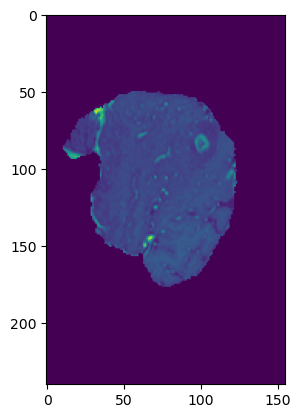

In [43]:
visualising_mri = dataset_training[10]["image"][0][0:][0:][70]
visualising_mri_segment = dataset_training[10]["seg"][0][0:][0:][70]

plt.imshow(visualising_mri)

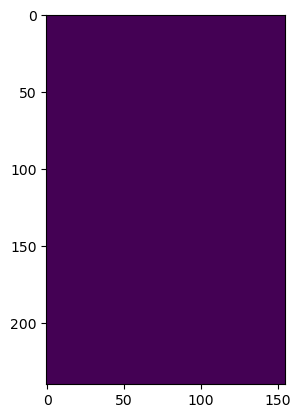

In [45]:
plt.imshow(visualising_mri_segment)

# TODO
- Data Preprocessing
- Choosing Data Loader -> Slice
- Choosing Encoder
- Choosing Decoder -> Append Encoder

add more as you go

In [ ]:
from monai.data import Dataset, CacheDataset,PersistentDataset, decollate_batch, list_data_collate
from glob import glob
from os import path, listdir
import pytorch_lightning as pl
from sklearn.model_selection import ShuffleSplit

from monai.transforms import (
    LoadImaged,
    SpatialPadd,
    EnsureChannelFirstd,
    Compose,
    NormalizeIntensityd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    MapTransform,
    CropForegroundd,
    EnsureTyped,
    EnsureType,
    Activations,
    AsDiscrete,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandSpatialCropSamplesd
)

from monai.data import partition_dataset
from monai.networks.nets import UNet,UNETR, SegResNet, BasicUnet
from monai.losses import TverskyLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import torch
import matplotlib.pyplot as plt
import numpy as np
import utilities.split_data as split_data
plt.style.use(['science','ieee'])
%matplotlib inline